In [ ]:
## This notebook is used to average the monthly ERA5 U-compontent wind data to get yearly data
## Created by Kendra Herweck

In [175]:
import netCDF4 as nc
import numpy as np
import datetime as dt  # Python standard library datetime  module
from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.table import Table
from astropy.io import ascii
from pandas import read_csv
from matplotlib.dates import DateFormatter
from pandas import DataFrame
from pandas import Grouper
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import xarray as xr
from glob import glob

In [24]:
##file is for 750 hPa
file = 'Data/Wind-Data/ERA/adaptor.mars.internal-1624564940.412504-16834-17-83b534cd-f968-442e-9568-51480c3210b6_1950-1978.nc'
ds = xr.open_mfdataset(file, concat_dim='time')
print(ds)
#print(ds['u'])

<xarray.Dataset>
Dimensions:    (latitude: 361, longitude: 1440, time: 116)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1978-12-01
Data variables:
    u          (time, latitude, longitude) float32 dask.array<chunksize=(116, 361, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-24 20:02:21 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...


In [25]:
time=0     ## 116 time units. J,F,N,D 1950-1978
lats = ds['latitude']
lons = ds['longitude']
wind = ds['u'][time,:,:]
lon, lat = np.meshgrid(lons, lats)

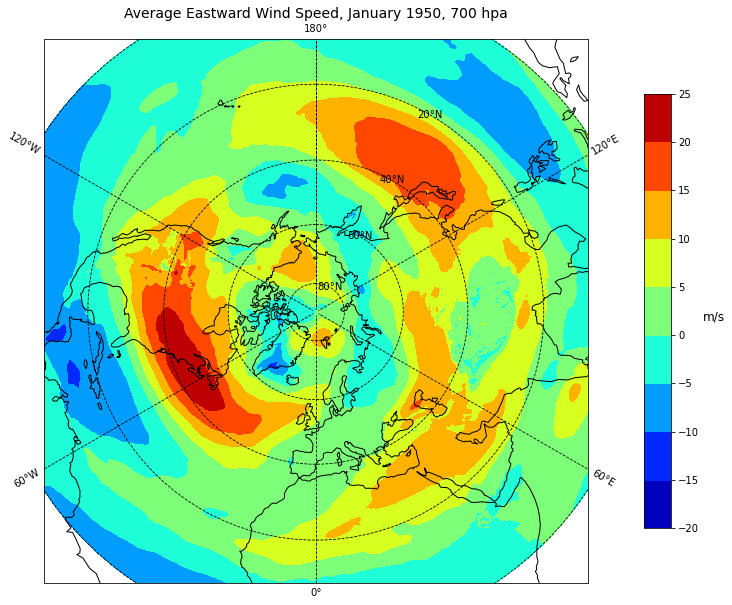

In [26]:
fig = plt.figure(figsize=(20,10))
#ax = plt.axes(projection=ccrs.Robinson())
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=90))
ax.set_global()
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black',draw_labels=True)
ax.set_extent([-180,180,10,90],ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

plt.contourf(lon, lat, wind, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.title('Average Eastward Wind Speed, January 1950, 700 hpa', size=14)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.05, aspect=16, shrink=0.8)
cb.set_label('m/s',size=12,rotation=0,labelpad=15)

## Climatological Avg

In [195]:
filename = 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-{}.nc'.format(1950)
ds=xr.open_dataset(filename)
print(ds)
ds.close()


<xarray.Dataset>
Dimensions:  (time: 1, x: 1440, y: 321)
Coordinates:
  * time     (time) float64 1.95e+03
Dimensions without coordinates: x, y
Data variables:
    lat      (y) float64 ...
    lon      (x) float64 ...
    U        (y, x) float64 ...


In [213]:
filename_list=[]
for i in range(1980,2021):
    filename = 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-{}.nc'.format(i)
    filename_list.append(filename)

#print(filename_list)
combined_ds = xr.open_mfdataset(filename_list)
#print(combined_ds)

lat_out  = combined_ds.variables['lat'][0,:]
lon_out  = combined_ds.variables['lon'][0,:]
print(len(lat_out))
print(lon_out.shape)

321
(1440,)


In [214]:
##Climatology: 1980-2020
filename_list=[]
for i in range(1980,2021):
    filename = 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-{}.nc'.format(i)
    filename_list.append(filename)

#print(filename_list)
combined_ds = xr.open_mfdataset(filename_list)
#print(combined_ds)

f = nc.Dataset('Climatology_ERA-WindSpeed_700hPa.nc', 'w')
f.createDimension('time', None)
f.createDimension('y', len(combined_ds['lat'][0,:]))
f.createDimension('x', len(combined_ds['lon'][0,:]))
#f.createDimension('level',len(combined_ds['lev']))
lats = f.createVariable('lat', float, ('y', ), zlib=True)
lons = f.createVariable('lon', float, ('x', ), zlib=True)
#levs = f.createVariable('lev',float, ('level', ), zlib= True)
wind = f.createVariable('U', float, ('y', 'x'), zlib=True, least_significant_digit=1, fill_value=0)

# create latitude and longitude 1D arrays
lat_out  = combined_ds.variables['lat'][0,:]
lon_out  = combined_ds.variables['lon'][0,:]

data = []
for i in range (0, len(lat_out)):
    for j in range(0,len(lon_out)):
        mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
        data.append(mean)
data_out = np.array(data)      ##1d array of data
data_out.shape = (len(lat_out),len(lon_out))     ##reshape to 2d array                 
f['U'][:] = data_out
f['lat'][:] = lat_out
f['lon'][:] = lon_out
# close file to write on disk
f.close()


<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon
<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time

<ipython-input-214-fab777f54941>:28: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(combined_ds['U'][:,i,j].values) #time,level,lat,lon


In [203]:
f.close()

## Low SIC Years Avg

In [38]:
##Years: 1950,1951,1952,1955,1958,1959,1961,1964,1966,1968,1970,1971,1974,1976,1977,1979,1981,1984,1987,1989,1990,1993,
##       1995,1997,1998,1999,2002,2005,2007,2010,2011,2012,2015,2016,2019,2020


In [215]:
filename_list=[]
for i in (1950,1951,1952,1955,1958,1959,1961,1964,1966,1968,1970,1971,1974,1976,1977,1979,1981,1984,1987,1989,1990,1993,
       1995,1997,1998,1999,2002,2005,2007,2010,2011,2012,2015,2016,2019,2020):
    filename = 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-{}.nc'.format(i)
    filename_list.append(filename)

print(filename_list)
combined_ds = xr.open_mfdataset(filename_list)
print(combined_ds)

['Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1950.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1951.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1952.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1955.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1958.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1959.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1961.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1964.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1966.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1968.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1970.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1971.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1974.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1976.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1977.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1979.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1981.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1984.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1987.nc', 'Data/Wind-Data/ERA/Yearly/ERA

## Low SIC & EP Nino Years

In [216]:
##Years: 1952,1970,1977,1987,1998,2007,2012

filename_list=[]
for i in (1952,1970,1977,1987,1998,2007,2012):
    filename = 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-{}.nc'.format(i)
    filename_list.append(filename)

print(filename_list)
combined_ds = xr.open_mfdataset(filename_list)
print(combined_ds)

['Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1952.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1970.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1977.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1987.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1998.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2007.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2012.nc']
<xarray.Dataset>
Dimensions:  (time: 7, x: 1440, y: 321)
Coordinates:
  * time     (time) float64 1.952e+03 1.97e+03 1.977e+03 ... 2.007e+03 2.012e+03
Dimensions without coordinates: x, y
Data variables:
    lat      (time, y) float64 dask.array<chunksize=(1, 321), meta=np.ndarray>
    lon      (time, x) float64 dask.array<chunksize=(1, 1440), meta=np.ndarray>
    U        (time, y, x) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>


## Low SIC & CP Nino Years

In [217]:
##Years: 1958,1959,1964,1966,1995,2005,2010,2015,2016,2020
filename_list=[]
for i in (1958,1959,1964,1966,1995,2005,2010,2015,2016,2020):
    filename = 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-{}.nc'.format(i)
    filename_list.append(filename)

print(filename_list)
combined_ds = xr.open_mfdataset(filename_list)
print(combined_ds)

['Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1958.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1959.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1964.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1966.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1995.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2005.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2010.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2015.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2016.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2020.nc']
<xarray.Dataset>
Dimensions:  (time: 10, x: 1440, y: 321)
Coordinates:
  * time     (time) float64 1.958e+03 1.959e+03 1.964e+03 ... 2.016e+03 2.02e+03
Dimensions without coordinates: x, y
Data variables:
    lat      (time, y) float64 dask.array<chunksize=(1, 321), meta=np.ndarray>
    lon      (time, x) float64 dask.array<chunksize=(1, 1440), meta=np.ndarray>
    U        (time, y, x) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>


## All CP Nino Years

In [218]:
##Years: 1954,1958,1959,1964,1966,1969,1978,1988,1992,1995,2003,2005,2010,2015,2016,2020
filename_list=[]
for i in (1954,1958,1959,1964,1966,1969,1978,1988,1992,1995,2003,2005,2010,2015,2016,2020):
    filename = 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-{}.nc'.format(i)
    filename_list.append(filename)

print(filename_list)
combined_ds = xr.open_mfdataset(filename_list)
print(combined_ds)

['Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1954.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1958.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1959.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1964.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1966.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1969.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1978.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1988.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1992.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1995.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2003.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2005.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2010.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2015.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2016.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2020.nc']
<xarray.Dataset>
Dimensions:  (time: 16, x: 1440, y: 321)
Coordinates:
  * time     (time) float64 1.954e+03 1.958e+03 1.959e+03 ... 2.016e+03 2.02e+03
Dimensions without coordinates:

## All EP Nino Years

In [219]:
##Years: 1952,1970,1973,1977,1983,1987,1998,2007,2012
filename_list=[]
for i in (1952,1970,1973,1977,1983,1987,1998,2007,2012):
    filename = 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-{}.nc'.format(i)
    filename_list.append(filename)

print(filename_list)
combined_ds = xr.open_mfdataset(filename_list)
print(combined_ds)

['Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1952.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1970.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1973.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1977.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1983.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1987.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-1998.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2007.nc', 'Data/Wind-Data/ERA/Yearly/ERA-WindSpeed-2012.nc']
<xarray.Dataset>
Dimensions:  (time: 9, x: 1440, y: 321)
Coordinates:
  * time     (time) float64 1.952e+03 1.97e+03 1.973e+03 ... 2.007e+03 2.012e+03
Dimensions without coordinates: x, y
Data variables:
    lat      (time, y) float64 dask.array<chunksize=(1, 321), meta=np.ndarray>
    lon      (time, x) float64 dask.array<chunksize=(1, 1440), meta=np.ndarray>
    U        (time, y, x) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
